In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from scipy.optimize import curve_fit

# Попытаться найти файл в нескольких типичных местах
candidates = [
    'datasets/students_simple.csv',
    'students_simple.csv'
]
csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Файл students_simple.csv не найден")

df = pd.read_csv(csv_path)
print("Файл загружен:", csv_path)
print("Форма данных:", df.shape)
print("Колонки:", list(df.columns))

N = 20

idx1 = N % 5
idx2 = (N**2 % 5) + 5

cols = list(df.columns)

col_x = cols[idx1]
col_y = cols[idx2]
print(f"Используем N={N}. Выбраны столбцы: X = {col_x} (index {idx1}), Y = {col_y} (index {idx2})")

# Выделяем серии, убираем NaN-пары
xy = df[[col_x, col_y]].dropna()
x = xy[col_x].astype(float).to_numpy()
y = xy[col_y].astype(float).to_numpy()
n = len(x)
print("Число пар (после удаления NaN):", n)

Файл загружен: students_simple.csv
Форма данных: (20, 10)
Колонки: ['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp', 'friends', 'test_time']
Используем N=20. Выбраны столбцы: X = height (index 0), Y = age (index 5)
Число пар (после удаления NaN): 20


In [8]:
# Ячейка 2: корреляции

# 1) Fechner 
# F = (N_p - N_m) / (N_p + N_m)
# где N_p = число, для которых sign(x_i - mean_x) == sign(y_i - mean_y)
#       N_m = число несовпадающих знаков
def fechner_corr(a, b):
    sx = np.sign(a - np.mean(a)) #отдаю массив -1 0 1 в зависимости от знака (mean - среднее арифм)
    sy = np.sign(b - np.mean(b))
    # matched: same sign (including both 0)
    matched = np.sum(sx == sy)
    unmatched = np.sum(sx != sy)
   
    N_plus = matched
    N_minus = unmatched
    if (N_plus + N_minus) == 0:
        return np.nan
    return (N_plus - N_minus) / (N_plus + N_minus), N_plus, N_minus

F_val, N_plus, N_minus = fechner_corr(x, y)

pearson_r, pearson_p = stats.pearsonr(x, y)

def pearson_ci(r, n, alpha=0.05):
    # z - через гиперболический обратный тангенс (что бы нормализовать данные и в них уже посчитать дов. интервал)
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2) # 95% alpha = 0.05сли α = 0.05 → (1 - α/2) = 0.975
# stats.norm.ppf(0.975) ≈ 1.96 значит, 95% значений нормального распределения лежат в диапазоне [-1.96, +1.96]
    lo_z, hi_z = z - z_crit * se, z + z_crit * se # Верхние и нижняя границы
    lo, hi = np.tanh(lo_z), np.tanh(hi_z) # обратное преобразование фишера
    return lo, hi

pearson_ci_lo, pearson_ci_hi = pearson_ci(pearson_r, n)

# 3) S
spearman_rho, spearman_p = stats.spearmanr(x, y)

# 4) K
kendall_tau, kendall_p = stats.kendalltau(x, y)

# Печать результатов в читаемом виде
print("\nКОРРЕЛЯЦИИ (пара X, Y):")
print(f"Fechner: F = {F_val:.4f} (N_plus={N_plus}, N_minus={N_minus})")
print(f"Pearson: r = {pearson_r:.4f}, p = {pearson_p:.4e}, 95% CI = [{pearson_ci_lo:.4f}, {pearson_ci_hi:.4f}]")
print(f"Spearman: rho = {spearman_rho:.4f}, p = {spearman_p:.4e}")
print(f"Kendall: tau = {kendall_tau:.4f}, p = {kendall_p:.4e}")



КОРРЕЛЯЦИИ (пара X, Y):
Fechner: F = 0.1000 (N_plus=11, N_minus=9)
Pearson: r = 0.1944, p = 4.1155e-01, 95% CI = [-0.2715, 0.5865]
Spearman: rho = 0.1750, p = 4.6048e-01
Kendall: tau = 0.1223, p = 4.6978e-01


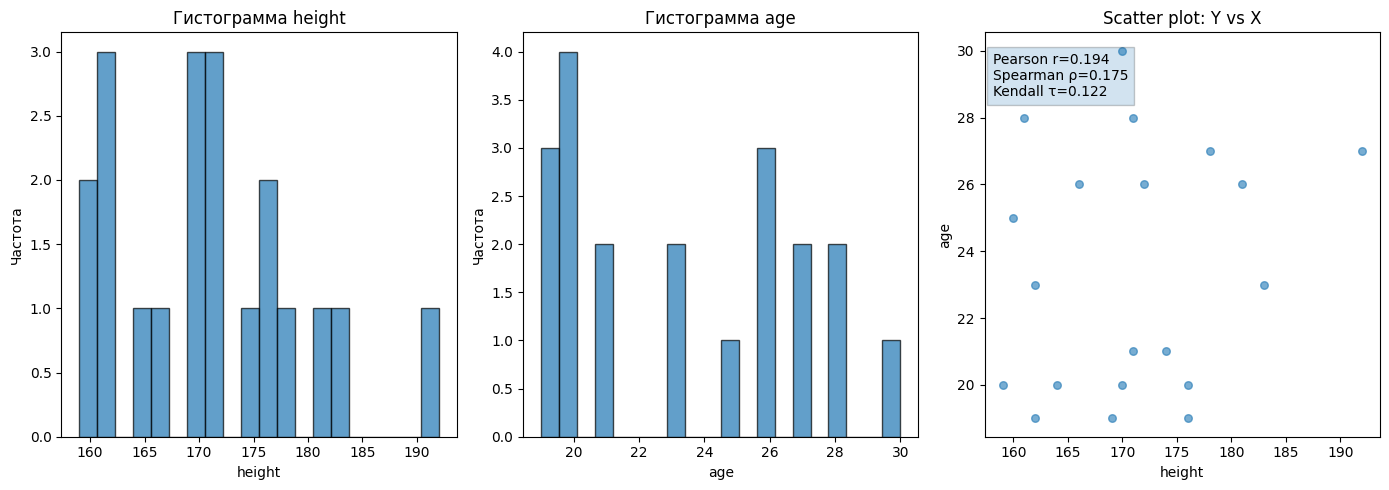

In [4]:
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.hist(x, bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Гистограмма {col_x}")
plt.xlabel(col_x)
plt.ylabel("Частота")

plt.subplot(1,3,2)
plt.hist(y, bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Гистограмма {col_y}")
plt.xlabel(col_y)
plt.ylabel("Частота")

plt.subplot(1,3,3)
plt.scatter(x, y, alpha=0.6, s=30)
plt.title("Scatter plot: Y vs X")
plt.xlabel(col_x)
plt.ylabel(col_y)
# подпись с коэффициентами корреляции
plt.text(0.02, 0.95, f"Pearson r={pearson_r:.3f}\nSpearman ρ={spearman_rho:.3f}\nKendall τ={kendall_tau:.3f}", 
         transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(alpha=0.2))
plt.tight_layout()
plt.show()


RMSE сравнение моделей:
      model                                                          params     rmse
  Quadratic [0.005344106398627786, -1.7714738480334034, 169.68908973925767] 3.440791
Exponential                     [12.701907530089379, 0.0035734412032965485] 3.471851
     Linear                         [0.0822534004498231, 9.347006533147725] 3.473647
 Hyperbolic                         [-2351.710712619802, 37.19701248712065] 3.479234


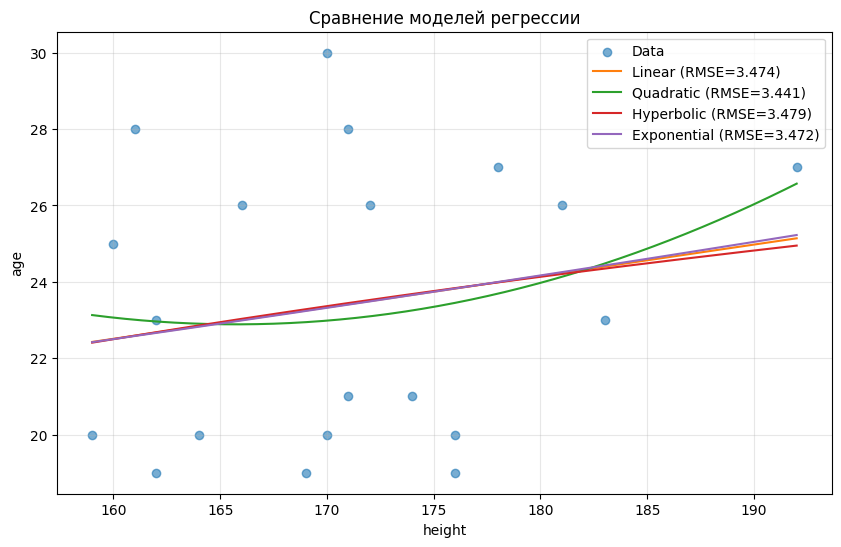

In [5]:
def linear_model(x, w1, w0):
    return w1 * x + w0

def quad_model(x, w2, w1, w0):
    return w2 * x**2 + w1 * x + w0

def hyperbolic_model(x, w1, w0):
    return w1 / (x + 1e-8) + w0

def exponential_model(x, a, b):
    return a * np.exp(b * x)

x_grid = np.linspace(np.min(x), np.max(x), 300)

# линейная
p_lin = np.polyfit(x, y, 1) #  находит наиболее подходящее полиномиальное уравнение для точек данных
y_lin_pred = np.polyval(p_lin, x) #находим массив всех предсказанных моделью значений y по x
y_lin_grid = np.polyval(p_lin, x_grid)
rmse_lin = np.sqrt(np.mean((y - y_lin_pred)**2)) # ошибка модели

# кв
p_quad = np.polyfit(x, y, 2)
y_quad_pred = np.polyval(p_quad, x)
y_quad_grid = np.polyval(p_quad, x_grid)
rmse_quad = np.sqrt(np.mean((y - y_quad_pred)**2))

# гиперболическая
try:
    popt_hyp, _ = curve_fit(hyperbolic_model, x, y, p0=[1.0, np.mean(y)]) # нелинейный метод наименьших квадратов для подгонки функции f к данным, p0 - старт
    y_hyp_pred = hyperbolic_model(x, *popt_hyp)
    y_hyp_grid = hyperbolic_model(x_grid, *popt_hyp)
    rmse_hyp = np.sqrt(np.mean((y - y_hyp_pred)**2))
except Exception as e:
    popt_hyp = None
    y_hyp_pred = np.full_like(y, np.nan)
    y_hyp_grid = np.full_like(x_grid, np.nan)
    rmse_hyp = np.inf
    print("Hyperbolic fit failed:", e)

# показательная
y_shift = 0.0
if np.any(y <= 0):
    y_shift = abs(np.min(y)) + 1e-6
ys_for_exp = y + y_shift
try:
    popt_exp, _ = curve_fit(exponential_model, x, ys_for_exp, p0=[np.mean(ys_for_exp), 0.0], maxfev=10000) # maxfev - кол-во итераций 
    y_exp_pred = exponential_model(x, *popt_exp) - y_shift
    y_exp_grid = exponential_model(x_grid, *popt_exp) - y_shift
    rmse_exp = np.sqrt(np.mean((y - y_exp_pred)**2))
except Exception as e:
    popt_exp = None
    y_exp_pred = np.full_like(y, np.nan)
    y_exp_grid = np.full_like(x_grid, np.nan)
    rmse_exp = np.inf
    print("Exponential fit failed:", e)

# Сводная таблица RMSE
models_summary = pd.DataFrame([
    {'model': 'Linear', 'params': p_lin.tolist(), 'rmse': rmse_lin},
    {'model': 'Quadratic', 'params': p_quad.tolist(), 'rmse': rmse_quad},
    {'model': 'Hyperbolic', 'params': (popt_hyp.tolist() if popt_hyp is not None else None), 'rmse': rmse_hyp},
    {'model': 'Exponential', 'params': (popt_exp.tolist() if popt_exp is not None else None), 'rmse': rmse_exp},
]).sort_values('rmse')

print("\nRMSE сравнение моделей:")
print(models_summary.to_string(index=False))

# Построим scatter и кривые
plt.figure(figsize=(10,6))
plt.scatter(x, y, label='Data', alpha=0.6)
plt.plot(x_grid, y_lin_grid, label=f'Linear (RMSE={rmse_lin:.3f})', color='C1')
plt.plot(x_grid, y_quad_grid, label=f'Quadratic (RMSE={rmse_quad:.3f})', color='C2')
if popt_hyp is not None:
    plt.plot(x_grid, y_hyp_grid, label=f'Hyperbolic (RMSE={rmse_hyp:.3f})', color='C3')
if popt_exp is not None:
    plt.plot(x_grid, y_exp_grid, label=f'Exponential (RMSE={rmse_exp:.3f})', color='C4')
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title("Сравнение моделей регрессии")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [6]:
def f_test_regression(y_true, y_pred, p):
    y_mean = np.mean(y_true)
    SSR = np.sum((y_pred - y_mean)**2)
    SSE = np.sum((y_true - y_pred)**2)
    MSR = SSR / p
    MSE = SSE / (len(y_true) - p - 1)
    F = MSR / MSE
    p_value = 1 - stats.f.cdf(F, p, len(y_true) - p - 1)
    return {'SSR': SSR, 'SSE': SSE, 'MSR': MSR, 'MSE': MSE, 'F': F, 'p_value': p_value}
##В регрессионном анализе F-критерий используется для оценки общей значимости модели:

#Рассчитайте сумму квадратов регрессии: SSR = Σ(ŷᵢ – ȳ)²
#Рассчитайте сумму квадратов ошибок: SSE = Σ(yᵢ – ŷᵢ)²
#Определите степени свободы: dfR = p (количество предикторов), dfE = n – p – 1
#Вычислите средние квадраты: MSR = SSR/dfR, MSE = SSE/dfE
#Рассчитайте F-статистику: F = MSR/MSE


# Считаем для каждой модели
res_lin = f_test_regression(y, y_lin_pred, p=1)
res_quad = f_test_regression(y, y_quad_pred, p=2)
if popt_hyp is not None:
    res_hyp = f_test_regression(y, y_hyp_pred, p=1)
else:
    res_hyp = None
if popt_exp is not None:
    res_exp = f_test_regression(y, y_exp_pred, p=1)
else:
    res_exp = None

print("\nтесты для моделей (общая значимость):")
print("Linear:", res_lin)
print("Quadratic:", res_quad)
print("Hyperbolic:", res_hyp)
print("Exponential:", res_exp)

best_model = models_summary.iloc[0]
worst_model = models_summary.iloc[-1]
print("\nЛучшая модель по RMSE:", best_model['model'], f"RMSE={best_model['rmse']:.4f}")
print("Худшая модель по RMSE:", worst_model['model'], f"RMSE={worst_model['rmse']:.4f}")

def show_f_for_name(name):
    if name == 'Linear':
        res = res_lin
    elif name == 'Quadratic':
        res = res_quad
    elif name == 'Hyperbolic':
        res = res_hyp
    elif name == 'Exponential':
        res = res_exp
    else:
        res = None
    print(f"\n{name} model F-test:")
    if res is None:
        print("  нет результата (не удалось подогнать модель)")
    else:
        print(f"  F = {res['F']:.4f}, p = {res['p_value']:.4e}, MSR = {res['MSR']:.4f}, MSE = {res['MSE']:.4f}")

show_f_for_name(best_model['model'])
show_f_for_name(worst_model['model'])


F-тесты для моделей (общая значимость):
Linear: {'SSR': np.float64(9.475591731819614), 'SSE': np.float64(241.3244082681804), 'MSR': np.float64(9.475591731819614), 'MSE': np.float64(13.406911570454467), 'F': np.float64(0.706769167680757), 'p_value': np.float64(0.41154747384889157)}
Quadratic: {'SSR': np.float64(14.019194834550786), 'SSE': np.float64(236.78080516544662), 'MSR': np.float64(7.009597417275393), 'MSE': np.float64(13.928282656790978), 'F': np.float64(0.5032635817350921), 'p_value': np.float64(0.6132833404125042)}
Hyperbolic: {'SSR': np.float64(8.698554037231315), 'SSE': np.float64(242.10144196358402), 'MSR': np.float64(8.698554037231315), 'MSE': np.float64(13.450080109088), 'F': np.float64(0.6467287902139589), 'p_value': np.float64(0.431778230684698)}
Exponential: {'SSR': np.float64(9.978005178744462), 'SSE': np.float64(241.07494434902117), 'MSR': np.float64(9.978005178744462), 'MSE': np.float64(13.39305246383451), 'F': np.float64(0.7450135214274896), 'p_value': np.float64(0

## Итоги лабораторной №2 — пояснения и выводы

**Входные данные и выбор переменных**
- Использованы два столбца из файла `students_simple.csv`, выбранные по формулам:
  - `idx1 = N % 5`
  - `idx2 = (N**2 % 5) + 5`
  (если индексы выходят за пределы числа колонок, применяется приведение по модулю).
- Очищены пары с пропусками (пары с NaN удалены).

**1. Корреляции**
На используемых данных нет статистически значимой корреляции между X и Y. Все коэффициенты корреляции показывают очень слабую положительную связь, от 0.1 до 2. Доверительный интервал Пирсона включает ноль, что подтверждает отсутствие значимой связи. Наблюдаемая слабая положительная тенденция, вероятно, является случайной и не имеет практической значимости. Не можем говорить о наличии устойчивой связи между этими переменными.


**3. Регрессии**
- Подбирались 4 модели:
  - Линейная: \(y = w_1 x + w_0\)
  - Квадратичная: \(y = w_2 x^2 + w_1 x + w_0\)
  - Гиперболическая: \(y = w_1 / x + w_0\) (осторожно с \(x=0\); код защищён смещением)
  - Экспоненциальная: \(y = a \, e^{b x}\) (в случае отрицательных y применяется сдвиг)
- Для каждой модели рассчитаны параметры, RMSE (среднеквадратическая ошибка). Модель с наименьшим RMSE — лучшая по точности описания зависимости x от y.

**4. Проверка регрессий (F-test)**
В результате проведенного регрессионного анализа были построены четыре модели: линейная, квадратичная, гиперболическая и показательная. Для каждой модели рассчитана среднеквадратическая ошибка (RMSE), которая характеризует среднее отклонение предсказанных значений от фактических данных. Чем меньше значение RMSE, тем лучше модель аппроксимирует исходные данные.

Сравнение показало, что наименьшую ошибку имеет квадратичная модель (RMSE = 3.4408), следовательно, она наиболее точно описывает зависимость между выбранными переменными.


**Ссылки на используемые формулы и определения**
---